# Data Mining Project : Analysis of intentional homicides by country and sex of victims 

In [69]:
# Data analysis imports
import pandas as pd
import seaborn as sns
import plotly.express as px
import numpy as np
from ydata_profiling import ProfileReport

# ML imports
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from scipy.stats import norm
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer
from sklearn.neighbors import kneighbors_graph
from tslearn.clustering import TimeSeriesKMeans
pd.set_option('display.max_columns', None)

## Prétraitement des données

### Transformation fichier en csv avec renommage

In [27]:
# Read the Excel file with the first two rows as header
read_file = pd.read_excel("./datasets/Intentional homicide victims by sex, counts and ra.xls", sheet_name=2, header=[0, 1])

# Write the dataframe object into a CSV file
read_file.to_csv("./datasets/raw_data.csv", index=None, header=True)

# Read the CSV file back into a dataframe
df = pd.read_csv('./datasets/raw_data.csv', header=[0, 1])

# Rename Highest level columns
df.columns = pd.MultiIndex.from_tuples(
    [(('Count' if 'Number of victims of intentional homicides by sex' in col else 'Rate' if 'Rates of intentional homicides by sex' in col else col[0]), col[1]) for col in df.columns]
)
df.columns = pd.MultiIndex.from_tuples(
    [(col[0] if col[0] != 'Unnamed: 0_level_0' else 'Info', col[1]) for col in df.columns]
)
df.columns = pd.MultiIndex.from_tuples(
    [(col[0] if col[0] != 'Unnamed: 1_level_0' else 'Info', col[1]) for col in df.columns]
)
df.columns = pd.MultiIndex.from_tuples(
    [(col[0] if col[0] != 'Unnamed: 2_level_0' else 'Info', col[1]) for col in df.columns]
)
df.columns = pd.MultiIndex.from_tuples(
    [(col[0] if col[0] != 'Unnamed: 3_level_0' else 'Info', col[1]) for col in df.columns]
)
df.columns = pd.MultiIndex.from_tuples(
    [(col[0] if col[0] != 'Unnamed: 4_level_0' else 'Info', col[1]) for col in df.columns]
)

df.head(10)


Info                                                     Count            \
   Region           Subregion   Country     Sex        Source  2000 2001 2002   
0  Africa     Northern Africa   Algeria  Female           CTS   NaN  NaN  NaN   
1  Africa     Northern Africa   Algeria    Male           CTS   NaN  NaN  NaN   
2  Africa     Northern Africa     Egypt  Female  CTS/External   NaN  NaN  NaN   
3  Africa     Northern Africa     Egypt    Male           CTS   NaN  NaN  NaN   
4  Africa     Northern Africa   Morocco  Female     UNSDC/CTS   NaN  NaN  NaN   
5  Africa     Northern Africa   Morocco    Male     UNSDC/CTS   NaN  NaN  NaN   
6  Africa     Northern Africa   Tunisia  Female      External   NaN  NaN  NaN   
7  Africa     Northern Africa   Tunisia    Male      External   NaN  NaN  NaN   
8  Africa  Sub-Saharan Africa  Botswana  Female            NP   NaN  NaN  NaN   
9  Africa  Sub-Saharan Africa  Botswana    Male            NP   NaN  NaN  NaN   

                                                                            \
  2003   2004   2005   2006   2007        2008        2009    2010    2011   
0  NaN    NaN    NaN    NaN    NaN         NaN         NaN     NaN     NaN   
1  NaN    NaN    NaN    NaN    NaN         NaN         NaN     NaN     NaN   
2  NaN   52.0   63.0  144.0  163.0  110.418685  193.000000   197.0   331.0   
3  NaN  270.0  459.0  405.0  517.0  856.581315  719.000000  1642.0  2372.0   
4  NaN    NaN    NaN    NaN    NaN         NaN   52.897959     NaN     NaN   
5  NaN    NaN    NaN    NaN    NaN         NaN  379.102041     NaN     NaN   
6  NaN    NaN    NaN    NaN    NaN         NaN         NaN     NaN     NaN   
7  NaN    NaN    NaN    NaN    NaN         NaN         NaN     NaN     NaN   
8  NaN    NaN    NaN    NaN    NaN         NaN         NaN     NaN     NaN   
9  NaN    NaN    NaN    NaN    NaN         NaN         NaN     NaN     NaN   

                                                                             \
          2012   2013        2014   2015   2016   2017   2018   2019   2020   
0    52.000000   39.0   85.481481   71.0   75.0   56.0   86.0   86.0  122.0   
1   195.000000  170.0  491.518519  475.0  467.0  468.0  482.0  433.0  532.0   
2   261.865211    NaN         NaN    NaN    NaN    NaN    NaN    NaN  165.0   
3  1945.134789    NaN         NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4    56.000000   66.0   59.000000   97.0  105.0  113.0   70.0  117.0   84.0   
5   327.000000  363.0  296.000000  334.0  489.0  648.0  440.0  510.0  374.0   
6          NaN    NaN         NaN    NaN    NaN    NaN    NaN  103.0  115.0   
7          NaN    NaN         NaN    NaN    NaN    NaN    NaN  468.0  447.0   
8          NaN    NaN         NaN    NaN    NaN    NaN    NaN    NaN  114.0   
9          NaN    NaN         NaN    NaN    NaN    NaN    NaN    NaN    5.0   

         Rate                                                         \
    2021 2000 2001 2002 2003      2004      2005      2006      2007   
0  160.0  NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN   
1  535.0  NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN   
2  296.0  NaN  NaN  NaN  NaN  0.135997  0.161524  0.362020  0.401793   
3    NaN  NaN  NaN  NaN  NaN  0.687261  1.145443  0.991362  1.241278   
4   99.0  NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN   
5  617.0  NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN   
6    NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN   
7    NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN   
8  100.0  NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN   
9    5.0  NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN   

                                                                         \
       2008      2009      2010      2011      2012      2013      2014   
0       NaN       NaN       NaN       NaN  0.284704  0.209345  0.449798   
1       NaN       NaN       NaN       NaN  1.026532  0.8

### Filtrer les sources et arrondir le nombre de victimes

In [28]:
# Filter out sources from the dataframe
df = df.iloc[:327]
df = df.drop(columns=[('Info', 'Source')])

# How to select Country
print(df[('Info', 'Country')])
# How to filter rows based on Country 
df_algeria = df[df[('Info', 'Country')] == 'Algeria']
print(df_algeria)

# Round Counts to nearest integer
rounded_counts = df['Count'].round(0)
df['Count'] = rounded_counts

0             Algeria
1             Algeria
2               Egypt
3               Egypt
4             Morocco
            ...      
322    American Samoa
323             Samoa
324             Samoa
325             Tonga
326             Tonga
Name: (Info, Country), Length: 327, dtype: object
     Info                                   Count                           \
   Region        Subregion  Country     Sex  2000 2001 2002 2003 2004 2005   
0  Africa  Northern Africa  Algeria  Female   NaN  NaN  NaN  NaN  NaN  NaN   
1  Africa  Northern Africa  Algeria    Male   NaN  NaN  NaN  NaN  NaN  NaN   

                                                                         \
  2006 2007 2008 2009 2010 2011   2012   2013        2014   2015   2016   
0  NaN  NaN  NaN  NaN  NaN  NaN   52.0   39.0   85.481481   71.0   75.0   
1  NaN  NaN  NaN  NaN  NaN  NaN  195.0  170.0  491.518519  475.0  467.0   

                                     Rate                                     \
    2017   201

### Ajouter des colonnes au DataFrame (Somme & moyenne du nb de victimes, Somme & moyenne du taux meurtre)

In [29]:
# Add a total victim count column to the dataframe
df[('Count', 'Total')] = df[['Count']].sum(axis=1)
df.head(10)

# Add the mean rate column to the dataframe
df[('Count', 'Mean')] = df[['Count']].mean(axis=1)
df.head(10)

# Add a total victim count column to the dataframe
df[('Rate', 'Total')] = df[['Rate']].sum(axis=1)
df.head(10)

# Add the mean rate column to the dataframe
df[('Rate', 'Mean')] = df[['Rate']].mean(axis=1)
df.head(10)

Info                                       Count                        \
   Region           Subregion   Country     Sex  2000 2001 2002 2003   2004   
0  Africa     Northern Africa   Algeria  Female   NaN  NaN  NaN  NaN    NaN   
1  Africa     Northern Africa   Algeria    Male   NaN  NaN  NaN  NaN    NaN   
2  Africa     Northern Africa     Egypt  Female   NaN  NaN  NaN  NaN   52.0   
3  Africa     Northern Africa     Egypt    Male   NaN  NaN  NaN  NaN  270.0   
4  Africa     Northern Africa   Morocco  Female   NaN  NaN  NaN  NaN    NaN   
5  Africa     Northern Africa   Morocco    Male   NaN  NaN  NaN  NaN    NaN   
6  Africa     Northern Africa   Tunisia  Female   NaN  NaN  NaN  NaN    NaN   
7  Africa     Northern Africa   Tunisia    Male   NaN  NaN  NaN  NaN    NaN   
8  Africa  Sub-Saharan Africa  Botswana  Female   NaN  NaN  NaN  NaN    NaN   
9  Africa  Sub-Saharan Africa  Botswana    Male   NaN  NaN  NaN  NaN    NaN   

                                                                            \
    2005   2006   2007   2008   2009    2010    2011    2012   2013   2014   
0    NaN    NaN    NaN    NaN    NaN     NaN     NaN    52.0   39.0   85.0   
1    NaN    NaN    NaN    NaN    NaN     NaN     NaN   195.0  170.0  492.0   
2   63.0  144.0  163.0  110.0  193.0   197.0   331.0   262.0    NaN    NaN   
3  459.0  405.0  517.0  857.0  719.0  1642.0  2372.0  1945.0    NaN    NaN   
4    NaN    NaN    NaN    NaN   53.0     NaN     NaN    56.0   66.0   59.0   
5    NaN    NaN    NaN    NaN  379.0     NaN     NaN   327.0  363.0  296.0   
6    NaN    NaN    NaN    NaN    NaN     NaN     NaN     NaN    NaN    NaN   
7    NaN    NaN    NaN    NaN    NaN     NaN     NaN     NaN    NaN    NaN   
8    NaN    NaN    NaN    NaN    NaN     NaN     NaN     NaN    NaN    NaN   
9    NaN    NaN    NaN    NaN    NaN     NaN     NaN     NaN    NaN    NaN   

                                                   Rate                 \
    2015   2016   2017   2018   2019   2020   2021 2000 2001 2002 2003   
0   71.0   75.0   56.0   86.0   86.0  122.0  160.0  NaN  NaN  NaN  NaN   
1  475.0  467.0  468.0  482.0  433.0  532.0  535.0  NaN  NaN  NaN  NaN   
2    NaN    NaN    NaN    NaN    NaN  165.0  296.0  NaN  NaN  NaN  NaN   
3    NaN    NaN    NaN    NaN    NaN    NaN    NaN  NaN  NaN  NaN  NaN   
4   97.0  105.0  113.0   70.0  117.0   84.0   99.0  NaN  NaN  NaN  NaN   
5  334.0  489.0  648.0  440.0  510.0  374.0  617.0  NaN  NaN  NaN  NaN   
6    NaN    NaN    NaN    NaN  103.0  115.0    NaN  NaN  NaN  NaN  NaN   
7    NaN    NaN    NaN    NaN  468.0  447.0    NaN  NaN  NaN  NaN  NaN   
8    NaN    NaN    NaN    NaN    NaN  114.0  100.0  NaN  NaN  NaN  NaN   
9    NaN    NaN    NaN    NaN    NaN    5.0    5.0  NaN  NaN  NaN  NaN   

                                                                         \
       2004      2005      2006      2007      2008      2009      2010   
0       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2  0.135997  0.161524  0.362020  0.401793  0.266849  0.457290  0.457324   
3  0.687261  1.145443  0.991362  1.241278  2.017095  1.660664  3.716972   
4       NaN       NaN       NaN       NaN       NaN  0.331329       NaN   
5       NaN       NaN       NaN       NaN       NaN  2.357967       NaN   
6       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
7       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
8       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
9       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

                                                                         \
       2011      2012      2013      2014      2015      2016      2017   
0       NaN  0.284704  0.209345  0.449798  0.366151  0.379113  0.277568   
1       NaN  1.026532  0.877596  2.487979  2.357059  2.271808  2.232685   
2  0.751744  0.581524       N

### Exporter les données nettoyées

In [30]:
# Save cleaned dataset
df.to_csv("./datasets/clean_data.csv", index=None, header=True)

### Visualize Data

In [31]:
df.describe()

Count                                                          \
               2000          2001          2002          2003          2004   
count    118.000000    126.000000    128.000000    132.000000    158.000000   
mean    1853.144068   1756.944444   1775.570312   1712.303030   1387.379747   
std     6310.328587   6313.509142   6386.937989   6137.534047   5398.421033   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       26.000000     21.000000     26.500000     23.750000     12.000000   
50%       81.500000     69.500000     65.000000     70.000000     41.500000   
75%      326.250000    275.250000    320.500000    319.250000    230.000000   
max    41600.000000  44052.000000  45787.000000  47102.000000  44535.000000   

                                                                             \
               2005          2006          2007          2008          2009   
count    168.000000    192.000000    202.000000    228.000000    234.000000   
mean    1332.369048   1266.437500   1201.668317   1154.232456   1113.081197   
std     5047.603825   4809.226848   4564.440058   4371.428379   4389.398790   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       17.750000     11.750000     13.500000     13.000000     11.250000   
50%       61.000000     45.500000     54.500000     61.000000     49.000000   
75%      325.000000    282.250000    290.250000    352.500000    269.500000   
max    43678.000000  45080.000000  43906.000000  46042.000000  47131.000000   

                                                                            \
               2010          2011          2012          2013         2014   
count    240.000000    236.000000    234.000000    228.000000    226.00000   
mean    1138.883333   1177.025424   1133.042735   1064.539474   1073.40708   
std     4446.473799   4538.407856   4662.573303   4566.957230   4737.25501   
min        0.000000      0.000000      0.000000      0.000000      0.00000   
25%       15.000000     14.750000     15.250000     15.000000     13.25000   
50%       61.000000     59.500000     52.500000     57.500000     54.50000   
75%      298.250000    323.750000    291.000000    254.500000    222.50000   
max    47777.000000  47650.000000  51591.000000  51973.000000  54786.00000   

                                                                             \
               2015          2016          2017          2018          2019   
count    231.000000    226.000000    238.000000    233.000000    240.000000   
mean    1077.593074   1257.123894   1208.189076   1158.892704   1067.920833   
std     4644.600908   4972.746633   5015.465108   4828.502784   4341.440031   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       15.000000     17.000000     18.000000     16.000000     15.750000   
50%       62.000000     68.000000     58.500000     63.000000     58.500000   
75%      289.000000    444.750000    389.750000    366.000000    263.750000   
max    53467.000000  56465.000000  58750.000000  51334.000000  40268.000000   

                                         Rate                          \
               2020          2021        2000        2001        2002   
count    230.000000    194.000000  118.000000  126.000000  128.000000   
mean    1036.969565   1064.654639    7.351927    7.093214    8.424719   
std     4511.418285   4122.984087   15.203305   15.061349   16.740331   
min        0.000000      0.000000    0.000000    0.000000    0.000000   
25%       14.250000     12.250000    1.232116    1.194306    1.274867   
50%       62.500000     55.000000    2.415010    2.435052    2.511939   
75%      259.000000    226.750000    5.303030    5.019328    8.211618   
max    43780.000000  31263.000000  126.425681  129.621224  130.291396   

                                                                               \
             2003        2004        2005       

## Quels sont les pays les plus meurtriers ?

### Top 10 des pays avec le plus grand nombre de victimes tout sexe confondus

In [32]:
# Victim counts by sex 
group_df = df.groupby(by=[('Info', 'Sex')]).sum()
group_df[['Count']]

# Sort the dataframe by the highest count of victims in descending order
group_df = df.groupby(by=[('Info', 'Country')]).sum()
group_df
df_sorted = group_df.sort_values(by=[('Count', 'Total')], ascending=False)
df_sorted[['Count']].head(10)

Count                             \
                                       2000     2001     2002     2003   
(Info, Country)                                                          
Brazil                              45343.0  47903.0  49657.0  51040.0   
India                               48167.0  46420.0  45736.0  44331.0   
Russian Federation                  41090.0  42921.0  44252.0  41764.0   
Mexico                              10737.0  10285.0  10088.0  10087.0   
Colombia                            26539.0  27840.0  28387.0  23523.0   
United States of America            15586.0  19033.0  16229.0  16528.0   
Venezuela (Bolivarian Republic of)   8022.0   7960.0   9617.0  11342.0   
South Africa                            0.0      0.0      0.0      0.0   
Iraq (Central Iraq)                     0.0      0.0      0.0      0.0   
Guatemala                               0.0      0.0      0.0      0.0   

                                                                        \
                                       2004     2005     2006     2007   
(Info, Country)                                                          
Brazil                              48369.0  47564.0  49102.0  47682.0   
India                               46490.0  45095.0  44961.0  45362.0   
Russian Federation                  39256.0  35636.0  28844.0  25377.0   
Mexico                               9329.0   9921.0  10452.0   8867.0   
Colombia                            20210.0  18111.0  17479.0  17198.0   
United States of America            16148.0  16740.0  17309.0  17128.0   
Venezuela (Bolivarian Republic of)   9719.0   9964.0  12257.0  13156.0   
South Africa                            0.0      0.0  19106.0  18400.0   
Iraq (Central Iraq)                     0.0      0.0      0.0      0.0   
Guatemala                            4507.0   5338.0   5885.0   5781.0   

                                                                        \
                                       2008     2009     2010     2011   
(Info, Country)                                                          
Brazil                              50069.0  51396.0  52243.0  52166.0   
India                               45999.0  45824.0  46460.0  47640.0   
Russian Federation                  18188.0  17659.0  16690.0  16175.0   
Mexico                              14006.0  19803.0  25703.0  26950.0   
Colombia                            16140.0  15817.0  15459.0  16125.0   
United States of America            16465.0  15399.0  14722.0  14661.0   
Venezuela (Bolivarian Republic of)  14589.0  13985.0  13080.0  14098.0   
South Africa                        18084.0  16767.0  15893.0  15554.0   
Iraq (Central Iraq)                  4452.0   2458.0   2553.0   2518.0   
Guatemala                            6292.0   6498.0   5960.0   5681.0   

                                                                        \
                                       2012     2013     2014     2015   
(Info, Country)                                                          
Brazil                              56314.0  56740.0  59620.0  58086.0   
India                               47478.0  45878.0  47356.0  44373.0   
Russian Federation                  16247.0  16033.0  16516.0  17811.0   
Mexico                              25750.0  22928.0  19911.0  20676.0   
Colombia                            16433.0  16359.0  17990.0  17314.0   
United States of America            14856.0  14319.0  14164.0  15883.0   
Venezuela (Bolivarian Republic of)  16072.0      0.0      0.0  15337.0   
South Africa                            0.0      0.0      0.0      0.0   
Iraq (Central Iraq)                  2594.0   3228.0   3029.0      0.0   
Guatemala                            5155.0   6074.0   5549.0   5470.0   

                                                                        \
                                       2016     2017     2018     2019   
(Info, Country)                       

### Top 10 des pays les plus féminicides (Nombre de victimes)

In [33]:
# Victim counts by sex 
filtered_df = df[df[('Info', 'Sex')] == 'Female']
filtered_df.head(10)

# Sort the dataframe by the highest count of female victims in descending order
df_sorted = filtered_df.sort_values(by=[('Count', 'Total')], ascending=False)
df_sorted = df_sorted[[('Info', 'Country'), ('Count', 'Total')]]
df_sorted.head(10)

,Info,Count
,Country,Total
173,India,368897.0
229,Russian Federation,127340.0
60,Brazil,88784.0
140,United States of America,80760.0
102,Mexico,50573.0
68,Colombia,31415.0
36,South Africa,26725.0
90,Guatemala,13649.0
132,Venezuela (Bolivarian Republic of),11392.0


### Top 10 des pays les plus homicides (Nombre de victimes masculines)

In [34]:
# Victim counts by sex 
filtered_df = df[df[('Info', 'Sex')] == 'Male']
filtered_df.head(10)

# Sort the dataframe by the highest count of female victims in descending order
df_sorted = filtered_df.sort_values(by=[('Count', 'Total')], ascending=False)
df_sorted = df_sorted[[('Info', 'Country'), ('Count', 'Total')]]
df_sorted.head(10)

,Info,Count
,Country,Total
61,Brazil,1006754.0
174,India,615455.0
103,Mexico,405856.0
230,Russian Federation,385161.0
69,Colombia,357596.0
141,United States of America,286672.0
133,Venezuela (Bolivarian Republic of),189342.0
37,South Africa,158797.0
194,Iraq (Central Iraq),102075.0


### Top 10 des pays les plus féminicides (Taux de meurtre moyen national)

In [35]:
# Victim counts by sex 
filtered_df = df[df[('Info', 'Sex')] == 'Female']
filtered_df.head(10)

# Sort the dataframe by the highest rate of female victims in descending order
df_sorted = filtered_df.sort_values(by=[('Rate', 'Mean')], ascending=False)
df_sorted = df_sorted[[('Info', 'Country'), ('Rate', 'Mean')]]
df_sorted.head(10)

,Info,Rate
,Country,Mean
82,El Salvador,22.672727
98,Jamaica,18.748425
36,South Africa,17.620295
96,Honduras,16.968470
90,Guatemala,15.311958
120,Saint Vincent and the Grenadines,14.947932
229,Russian Federation,14.288587
56,Belize,13.805505
92,Guyana,12.733079


### Top 10 des pays les plus féminicides (Taux de meurtre national)

In [36]:
# Victim counts by sex 
filtered_df = df[df[('Info', 'Sex')] == 'Female']
filtered_df.head(10)

# Sort the dataframe by the highest rate of female victims in descending order
df_sorted = filtered_df.sort_values(by=[('Rate', 'Total')], ascending=False)
df_sorted = df_sorted[[('Info', 'Country'), ('Rate', 'Total')]]
df_sorted.head(10)

,Info,Rate
,Country,Total
82,El Salvador,204.054544
98,Jamaica,168.735823
229,Russian Federation,164.318750
96,Honduras,144.231991
90,Guatemala,137.807625
68,Colombia,137.294728
120,Saint Vincent and the Grenadines,112.109490
92,Guyana,108.231167
52,Bahamas,104.664286


### Top 10 des pays les plus homicides (Taux de meurtre moyen masculin national)

In [37]:
# Victim counts by sex 
filtered_df = df[df[('Info', 'Sex')] == 'Male']
filtered_df.head(10)

# Sort the dataframe by the highest rate of female victims in descending order
df_sorted = filtered_df.sort_values(by=[('Rate', 'Mean')], ascending=False)
df_sorted = df_sorted[[('Info', 'Country'), ('Rate', 'Mean')]]
df_sorted.head(10)

,Info,Rate
,Country,Mean
83,El Salvador,202.553722
97,Honduras,188.364661
99,Jamaica,171.154700
133,Venezuela (Bolivarian Republic of),159.444915
69,Colombia,138.845282
129,United States Virgin Islands,138.050756
117,Saint Kitts and Nevis,126.699768
57,Belize,114.167667
37,South Africa,111.985498


### Top 10 des pays les plus homicides (Taux de meurtre masculin national)

In [38]:
# Victim counts by sex 
filtered_df = df[df[('Info', 'Sex')] == 'Male']
filtered_df.head(10)

# Sort the dataframe by the highest rate of female victims in descending order
df_sorted = filtered_df.sort_values(by=[('Rate', 'Total')], ascending=False)
df_sorted = df_sorted[[('Info', 'Country'), ('Rate', 'Total')]]
df_sorted.head(10)

,Info,Rate
,Country,Total
83,El Salvador,1822.983499
97,Honduras,1601.099621
69,Colombia,1596.720745
99,Jamaica,1540.392299
133,Venezuela (Bolivarian Republic of),1355.281776
61,Brazil,1043.046477
91,Guatemala,996.863286
129,United States Virgin Islands,966.355291
53,Bahamas,955.396919


#### Courbe évolution du nombre de victime par année

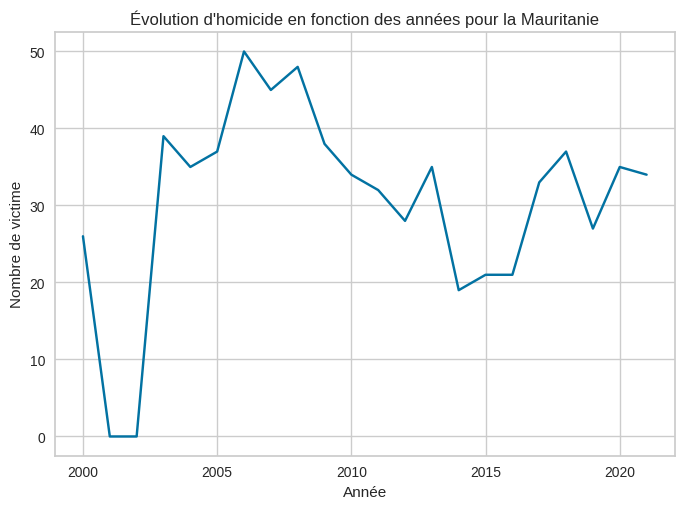

In [39]:
filtered_df = df[df[('Info', 'Country')] == 'Mauritius']

group_df = filtered_df.groupby(by=[('Info', 'Country')]).sum()

group_df = group_df[['Count']]

df_transposed = group_df.transpose().reset_index()
df_transposed.columns = ['Info', 'Year', 'Count']
df_transposed = df_transposed[0:22]
df_transposed['Year'] = pd.to_numeric(df_transposed['Year'])
df_transposed

sns.lineplot(x='Year', y='Count', data=df_transposed)
plt.title("Évolution d'homicide en fonction des années pour la Mauritanie")
plt.xlabel("Année")
plt.ylabel("Nombre de victime")

plt.show()

## On veut faire le Kmeans sur tout sauf la Region (Africa, Europe ...)

In [40]:
tampon = df.groupby(by=[('Info', 'Region')]).sum()
nb_regions = len(tampon)
print("Nombre de régions différentes :",nb_regions)

Nombre de régions différentes : 5


Voici ce qu'il se passe lorsqu'on essaie de lancer un Kmeans sur nos données telles qu'elles : 
> ValueError: Input X contains NaN.  
> KMeans does not accept missing values encoded as NaN natively. For supervised learning, [...]

On ne peut pas à cause des NaN dans nos données.  
Il se pose alors la question de quoi faire de ces NaN :  
Un NaN peut signifier soit une donnée manquante, soit zéro meurtres.  

Nous pouvons soit remplacer ces données par des zéros, mais cela fausserait les analyses suivantes, soit les remplacer par la moyenne du pays sur les données que l'on connait déjà.

Nous décidons de remplacer par la moyenne dans un premier temps et nous comparerons les résultats avec ou sans.

In [41]:
# Calculer la moyenne du nombre de victimes et du taux de victimes de chaque ligne et remplacer les NaN par ces valeurs
def replace_nan_with_mean(row, top_col_name):
    return row.fillna(row[(top_col_name,'Mean')])

resu1 = df.apply(lambda row: replace_nan_with_mean(row[['Count']], 'Count'), axis=1)
resu2 = df.apply(lambda row: replace_nan_with_mean(row[['Rate']], 'Rate'), axis=1)

df_copyyy = df.copy()
df_copyyy['Count'] = resu1['Count']
df_copyyy['Rate'] = resu2['Rate'] 

df_copyyy.head(5)

/tmp/ipykernel_5624/2711387832.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return row.fillna(row[(top_col_name,'Mean')])
/tmp/ipykernel_5624/2711387832.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return row.fillna(row[(top_col_name,'Mean')])
/tmp/ipykernel_5624/2711387832.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
 

Info                                          Count               \
   Region        Subregion  Country     Sex         2000         2001   
0  Africa  Northern Africa  Algeria  Female   151.272727   151.272727   
1  Africa  Northern Africa  Algeria    Male   772.545455   772.545455   
2  Africa  Northern Africa    Egypt  Female   329.333333   329.333333   
3  Africa  Northern Africa    Egypt    Male  1837.200000  1837.200000   
4  Africa  Northern Africa  Morocco  Female   153.166667   153.166667   

                                                                             \
          2002         2003        2004        2005        2006        2007   
0   151.272727   151.272727  151.272727  151.272727  151.272727  151.272727   
1   772.545455   772.545455  772.545455  772.545455  772.545455  772.545455   
2   329.333333   329.333333   52.000000   63.000000  144.000000  163.000000   
3  1837.200000  1837.200000  270.000000  459.000000  405.000000  517.000000   
4   153.166667   153.166667  153.166667  153.166667  153.166667  153.166667   

                                                                          \
         2008        2009         2010         2011    2012         2013   
0  151.272727  151.272727   151.272727   151.272727    52.0    39.000000   
1  772.545455  772.545455   772.545455   772.545455   195.0   170.000000   
2  110.000000  193.000000   197.000000   331.000000   262.0   329.333333   
3  857.000000  719.000000  1642.000000  2372.000000  1945.0  1837.200000   
4  153.166667   53.000000   153.166667   153.166667    56.0    66.000000   

                                                                    \
          2014         2015         2016         2017         2018   
0    85.000000    71.000000    75.000000    56.000000    86.000000   
1   492.000000   475.000000   467.000000   468.000000   482.000000   
2   329.333333   329.333333   329.333333   329.333333   329.333333   
3  1837.200000  1837.200000  1837.200000  1837.200000  1837.200000   
4    59.000000    97.000000   105.000000   113.000000    70.000000   

                                    Rate                                \
          2019    2020    2021      2000      2001      2002      2003   
0    86.000000   122.0   160.0  0.746483  0.746483  0.746483  0.746483   
1   433.000000   532.0   535.0  3.687608  3.687608  3.687608  3.687608   
2   329.333333   165.0   296.0  0.739147  0.739147  0.739147  0.739147   
3  1837.200000  1837.2  1837.2  4.184167  4.184167  4.184167  4.184167   
4   117.000000    84.0    99.0  0.875571  0.875571  0.875571  0.875571   

                                                                         \
       2004      2005      2006      2007      2008      2009      2010   
0  0.746483  0.746483  0.746483  0.746483  0.746483  0.746483  0.746483   
1  3.687608  3.687608  3.687608  3.687608  3.687608  3.687608  3.687608   
2  0.135997  0.161524  0.362020  0.401793  0.266849  0.457290  0.457324   
3  0.687261  1.145443  0.991362  1.241278  2.017095  1.660664  3.716972   
4  0.875571  0.875571  0.875571  0.875571  0.875571  0.331329  0.875571   

                                                                         \
       2011      2012      2013      2014      2015      2016      2017   
0  0.746483  0.284704  0.209345  0.449798  0.366151  0.379113  0.277568   
1  3.687608  1.026532  0.877596  2.487979  2.357059  2.271808  2.232685   
2  0.751744  0.581524  0.739147  0.739147  0.739147  0.739147  0.739147   
3  5.251376  4.209383  4.184167  4.184167  4.184167  4.184167  4.184167   
4  0.875571  0.337462  0.392560  0.346492  0.562780  0.601987  0.640348   

                                            Count                    Rate  \
       2018      2019      2020      2021   Total         Mean      Total   
0  0.418198  0.410531  0.572266  0.737983   832.0   151.272727   4.105657   
1  2.256279  1.990173  2.403662  2.378069  4249.0   772.545455  20.281842   
2  0.739147  0.739147  0.310689  0.5

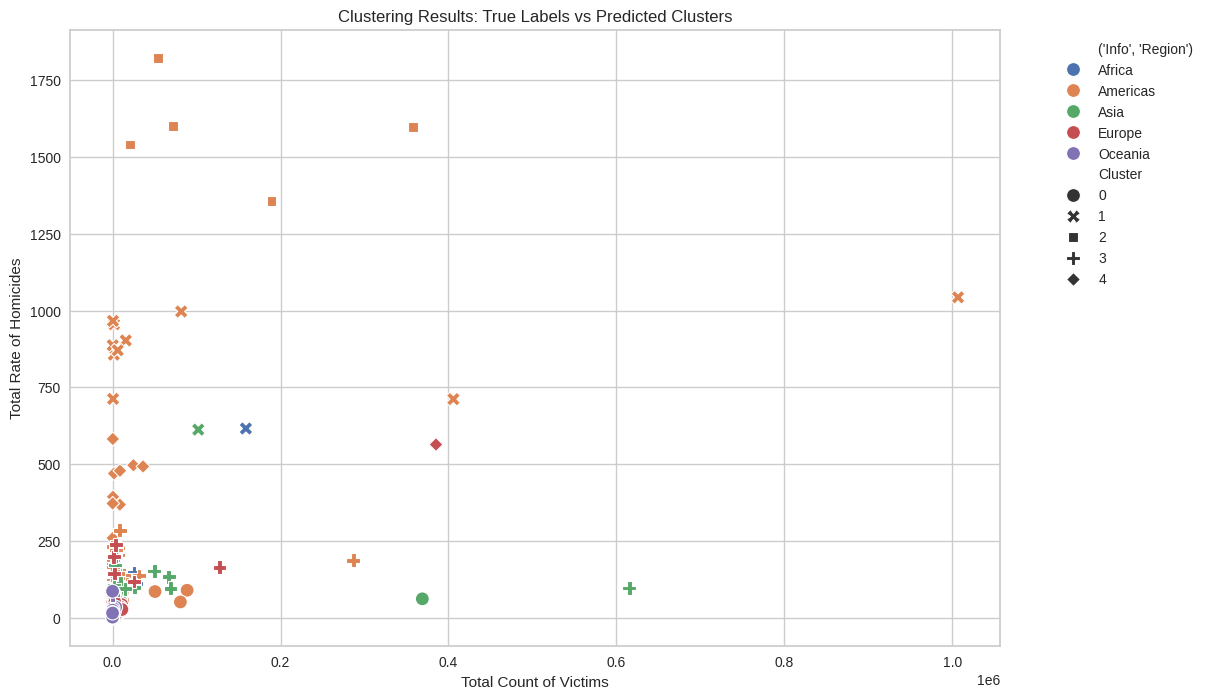

In [42]:
df_pour_kmeans = df_copyyy.copy().drop(columns=[('Info', 'Region')])

onehot = OneHotEncoder()

# a =pd.get_dummies(df_pour_kmeans[[('Info', 'Subregion')]], dtype=float)
# print(a)

subregion_encoded = pd.DataFrame(onehot.fit_transform(df_pour_kmeans[[('Info', 'Subregion')]]).toarray(), index=df_pour_kmeans.index)
country_encoded = pd.DataFrame(onehot.fit_transform(df_pour_kmeans[[('Info', 'Country')]]).toarray(), index=df_pour_kmeans.index)
sex_encoded = pd.DataFrame(onehot.fit_transform(df_pour_kmeans[[('Info', 'Sex')]]).toarray(), index=df_pour_kmeans.index)

sc = StandardScaler()
df_pour_kmeans['Count'] = sc.fit_transform(df_pour_kmeans['Count'])

df_pour_kmeans = df_pour_kmeans.drop(columns=[('Info', 'Subregion'), ('Info', 'Country'), ('Info', 'Sex')])
df_pour_kmeans = pd.concat([df_pour_kmeans, subregion_encoded, country_encoded, sex_encoded], axis=1)

# # df_pour_kmeans[[('Info', 'Subregion')]] = encode_subregion
# # df_pour_kmeans[[('Info', 'Country')]] = encode_country
# # df_pour_kmeans[[('Info', 'Sex')]] = enocde_sex

# # df_pour_kmeans.head(20)


kmeans = KMeans(n_clusters=5, random_state=0).fit(df_pour_kmeans)

kmeans.labels_

df_copyyy['Cluster'] = kmeans.labels_

# Plot the results of clustering
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_copyyy, x=('Count', 'Total'), y=('Rate', 'Total'), hue=('Info', 'Region'), style='Cluster', palette='deep', s=100)
plt.title('Clustering Results: True Labels vs Predicted Clusters')
plt.xlabel('Total Count of Victims')
plt.ylabel('Total Rate of Homicides')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# df_copyyy.head(100)

## Analyse

Les résultats sont décevants, mais prévisible puisqu'on donne énormément de données sans rapport. Par exemple, le sexe des victimes. Entre autres, on utilise à la fois le Nombre de victimes (normalisé) et le Taux de meurtre. 

Les clusters observés ne correspondent pas aux régions réelles, par exemple : on remarque que les Amériques possèdent des points dans chacun des clusters.

Il nous semble intéressant de chercher à utiliser la Régionalisation comme vue au dernier CM.

# Peut-on trouver des tendances de meurtres dans les régions voisines ou dans les pays dans le temps?

## Régionalisation

Étant donné que nos données correspondent à des pays, il semble plus que pertinent de se servir de la Regionalisation pour améliorer le clustering. Or, nous ne possédons pas les latitudes et longitudes des pays. Nous devons donc compléter nos données.

In [43]:
# from countryinfo import CountryInfo
# import time
# df_pos = df_copyyy.copy()

# def get_lat_long(country):
#     try:
#         pos = CountryInfo(country)
#         location = pos.info()
#         time.sleep(1)  
#         if location:
#             return pd.Series([location['latlng'][0], location['latlng'][1]])
#         else:
#             return pd.Series([None, None])
#     except Exception as e:
#         print("Error for", country, ":", e)
#         return pd.Series([None, None])

# df_pos[['Latitude', 'Longitude']] = df_copyyy[('Info', 'Country')].apply(lambda x: get_lat_long(x))

# df_pos.head()

In [44]:
# df_latlong = df_pos.copy()
# df_latlong = df_latlong.drop(df_latlong.filter(regex="Count|Rate|Region|Subregion|Sex|Cluster").columns.difference([('Info', 'Country')]), axis=1)
# df_latlong = df_latlong.drop_duplicates(subset=[('Info', 'Country')])
# df_latlong.to_csv("./datasets/clean_data_pos.csv", index=None, header=True)

In [45]:
df_latlong = pd.read_csv('./datasets/clean_data_pos.csv')
df_latlong.head()

,Country,Latitude,Longitude
0,Algeria,28.0,3.0
1,Egypt,27.0,30.0
2,Morocco,32.0,-5.0
3,Tunisia,34.0,9.0
4,Botswana,-22.0,24.0


In [46]:
df_sum_sex = df_copyyy.groupby(by=[('Info', 'Country')]).sum()
df_sum_sex = df_sum_sex.drop(df_sum_sex.filter(regex="Info"), axis=1)

df_sum_sex =  df_sum_sex.drop(columns=[('Rate', 'Total'), ('Rate', 'Mean')])

df_sum_sex[('Rate', 'Total')] = df_sum_sex[['Rate']].sum(axis=1)
df_sum_sex[('Rate', 'Mean')] = df_sum_sex[['Rate']].mean(axis=1)

df_sum_sex = df_sum_sex[['Rate']]

# sc = StandardScaler()
# df_sum_sex[[('Rate', 'Total')]] = sc.fit_transform(df_sum_sex[[('Rate', 'Total')]])
df_sum_sex.head()


Rate                                              \
                      2000       2001       2002       2003       2004   
(Info, Country)                                                          
Afghanistan       1.808804   1.808804   1.808804   1.808804   1.808804   
Albania           8.290013  14.032480  13.906631  10.796440   8.594947   
Algeria           4.434091   4.434091   4.434091   4.434091   4.434091   
American Samoa   32.867470  32.867470  32.867470  32.867470  32.867470   
Andorra           3.025471   3.025471   3.025471   3.025471   3.025471   

                                                                        \
                      2005       2006       2007       2008       2009   
(Info, Country)                                                          
Afghanistan       1.808804   1.808804   1.808804   1.808804   1.808804   
Albania          10.194898   6.338589   7.065027   6.304467   5.798391   
Algeria           4.434091   4.434091   4.434091   4.434091   4.434091   
American Samoa   32.867470  32.867470  32.867470  32.867470  32.867470   
Andorra           3.025471   3.025471   0.000000   2.712710   2.772771   

                                                                        \
                      2010       2011       2012       2013       2014   
(Info, Country)                                                          
Afghanistan       1.808804   1.808804   1.808804   1.808804   1.808804   
Albania           8.433239   9.772977  10.835448   8.571724   9.267660   
Algeria           4.434091   4.434091   1.311237   1.086941   2.937777   
American Samoa   32.867470  32.867470  32.867470  32.867470  32.867470   
Andorra           2.754252   2.803280   0.000000   0.000000   0.000000   

                                                                      \
                      2015      2016       2017       2018      2019   
(Info, Country)                                                        
Afghanistan       1.808804  1.808804   1.808804   1.439053  1.274152   
Albania           4.433667  6.305813   4.369763   4.583406  4.520209   
Algeria           2.723210  2.650921   2.510253   2.674478  2.400704   
American Samoa   32.867470  0.000000  28.329371  53.839304  0.000000   
Andorra           0.000000  3.025471   3.025471   3.025471  3.025471   

                                                              
                      2020       2021       Total       Mean  
(Info, Country)                                               
Afghanistan       1.808804   1.808804   38.889279   3.381676  
Albania           4.254827   4.626828  171.297444  14.895430  
Algeria           2.975927   3.116052   77.596588   6.747529  
American Samoa   32.867470  32.867470  673.783132  58.589838  
Andorra           6.145625   3.025471   53.494291   4.651677

In [47]:
connectivity = kneighbors_graph(df_latlong.drop('Country', axis=1), n_neighbors=30)
model = AgglomerativeClustering(n_clusters=7, connectivity=connectivity).fit(df_sum_sex)

In [48]:
clustered = model.labels_
print(clustered)

[2 2 2 3 2 3 3 2 2 2 2 2 2 0 2 3 2 2 0 3 2 2 2 2 1 3 2 2 2 3 2 2 3 2 2 2 1
 2 2 2 1 2 2 2 1 1 3 2 4 2 2 2 2 2 1 2 2 2 2 3 3 1 1 3 2 5 2 2 2 2 3 6 2 2
 2 2 6 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 3 2 3 2 2 0 2 2 3 2 2 2 3 3 3
 3 2 2 0 2 2 2 2 3 2 2 0 0 2 0 2 2 2 2 3 2 2 2 0 2 2 2 3 2 2 2 3 2 0 2 2 3
 2 3 3 2 2 2 2 2 3 6 2 3 2 2 4 2]


In [49]:
import folium

def create_map():
    colors = ['red', 'blue', 'green', 'yellow', 'orange', 'brown', 'black']
    map_center = [df_latlong['Latitude'].mean(), df_latlong['Longitude'].mean()]
    folium_map = folium.Map(location=map_center, zoom_start=3)

    # Add circle markers to the map
    for i, row in df_latlong.iterrows():
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=6, # Size of the circle marker
            color=colors[clustered[i]], # Color based on the cluster
            fill=False, # Enable fill
            fill_color=colors[clustered[i]], # Fill color
            fill_opacity=0.6, # Opacity of the fill
            popup=row['Country'] # Popup to show city name
        ).add_to(folium_map)
    return folium_map

folium_map = create_map()
# Display the map
folium_map

In [50]:
model = AgglomerativeClustering(n_clusters=7).fit(df_sum_sex)

In [51]:
clustered = model.labels_
print(clustered)

[5 2 5 0 5 0 0 2 5 2 5 5 5 1 5 0 2 5 3 0 5 2 5 2 1 0 5 5 2 0 2 5 0 2 5 5 3
 0 5 2 1 5 5 5 0 1 0 5 4 2 2 2 5 5 1 2 5 5 5 0 0 3 1 0 5 4 5 5 2 2 0 3 2 5
 5 5 4 5 5 0 2 2 5 2 2 5 2 5 5 2 5 2 5 0 5 5 0 2 0 5 2 1 5 5 0 5 5 5 0 0 0
 0 5 5 1 5 5 2 5 0 5 2 6 1 5 1 2 5 5 5 0 5 5 5 6 5 2 5 0 5 5 5 2 2 3 2 5 0
 2 0 0 5 5 5 5 5 0 6 2 0 5 5 6 2]


In [52]:
import folium

def create_map():
    colors = ['red', 'blue', 'green', 'yellow', 'orange', 'brown', 'black']
    map_center = [df_latlong['Latitude'].mean(), df_latlong['Longitude'].mean()]
    folium_map = folium.Map(location=map_center, zoom_start=3)

    # Add circle markers to the map
    for i, row in df_latlong.iterrows():
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=6, # Size of the circle marker
            color=colors[clustered[i]], # Color based on the cluster
            fill=False, # Enable fill
            fill_color=colors[clustered[i]], # Fill color
            fill_opacity=0.6, # Opacity of the fill
            popup=row['Country'] # Popup to show city name
        ).add_to(folium_map)
    return folium_map

folium_map = create_map()
# Display the map
folium_map

In [53]:
connectivity = kneighbors_graph(df_latlong.drop('Country', axis=1), n_neighbors=30)
model = AgglomerativeClustering(n_clusters=30, connectivity=connectivity).fit(df_sum_sex)

clustered = model.labels_
print(clustered)

def create_map():
    colors = [
        "Red", "Green", "Blue", "Yellow", "Orange", "Purple", "Pink", "Brown", "Gray", "Black",
        "White", "Cyan", "Magenta", "Lime", "Indigo", "Violet", "Turquoise", "Beige", "Lavender", "Maroon",
        "Navy", "Teal", "Olive", "Coral", "Gold", "Silver", "Crimson", "Aqua", "Mint", "Peach"
    ]
    map_center = [df_latlong['Latitude'].mean(), df_latlong['Longitude'].mean()]
    folium_map = folium.Map(location=map_center, zoom_start=3)

    # Add circle markers to the map
    for i, row in df_latlong.iterrows():
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=6, # Size of the circle marker
            color=colors[clustered[i]], # Color based on the cluster
            fill=False, # Enable fill
            fill_color=colors[clustered[i]], # Fill color
            fill_opacity=0.6, # Opacity of the fill
            popup=row['Country'] # Popup to show city name
        ).add_to(folium_map)
    return folium_map

folium_map = create_map()
# Display the map
folium_map

[ 4  1  1  9  4  0  9  6  1  6  4  4  1  8  4 11  6  1 19 11  1  6  5  2
  7 12  5  5 10 12  2  5 12  2  5  5 16 10  5  2  7  5  5  5  3  3 12  5
 27  2 10  2  5  5  3 10  5  5  5 12 12 15  3 14  5 23  5  5  2  2 14 29
  1  4  1  4 18  4  1 24  6  1  1  6  1  1  6  4  4  6  4  6  1 25  4  4
 11  1  0  1  6  8  4  4  0  1  4  4  0  0 11 11  4  4  8  4  4  6  1  0
  1  2 26 21  4 28  6  4  4  1  9  4  1  4 20  4  6  4 11  4  4  1 11  2
 17  6  1  0  2  9 11  4  4  1  1  1 24 22  6 24  1  5 13 10]


In [54]:
model = AgglomerativeClustering(n_clusters=30).fit(df_sum_sex)

clustered = model.labels_
print(clustered)

folium_map = create_map()
# Display the map
folium_map

[ 8  3 14  9  8  0  6  4 14  7  8  8 14  5 12 11  7 14 20 11 14  4 14  7
  1 29  8 14  4  0  7 14  0  3 12 12  2 13  8  7 24  8  8  8 22 10  0 14
 18  7  4  3 14 14 10  4  8 14  8 11 11  2 10  9 12 15 14  8  3  3  9 25
  3  8 14  8 19 12 14 11  4  3 14  7  3 14  4  8 12  7  8  4 14 26  8 12
 13  3 29 14  7 10  8  8  9 14  8 12  0  0 13 11  8  8  5 12  8  4 14  6
  8  3 17  1 12 16  7 12 12 14  6 12 14  8 23  8  7  8 13  8  8 14  4  3
 21  7 14  0  3  6 11  8  8 14 14  8 13 27  7 11 14  8 28  4]


# Analyse
Comme on peut le remarquer, notre regionalization les résultats ne sont pas parfait mais on peut reconnaitre quelque régions telle qu'en Europe, Asie du Sud Ouest, Amérique du Nord et autour de Cuba. On remarque qu'en retirant la matrice de connectivité les résultats sont beaucoup plus random.

# Peut on trouver une retrouver une évolution dans le nombre de meurtre par année ?

## Dans la suite on souhaite faire deux dataset, un pour les crimes par année, un par pour les ratios par année

In [62]:
df_count = df[['Info', 'Count']].copy()
df_count = df_count.droplevel(0, axis=1)
df_count.head()

,Region,Subregion,Country,Sex,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,Total,Mean
0,Africa,Northern Africa,Algeria,Female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,39.0,85.0,71.0,75.0,56.0,86.0,86.0,122.0,160.0,832.0,151.272727
1,Africa,Northern Africa,Algeria,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,195.0,170.0,492.0,475.0,467.0,468.0,482.0,433.0,532.0,535.0,4249.0,772.545455
2,Africa,Northern Africa,Egypt,Female,NaN,NaN,NaN,NaN,52.0,63.0,144.0,163.0,110.0,193.0,197.0,331.0,262.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,165.0,296.0,1976.0,329.333333
3,Africa,Northern Africa,Egypt,Male,NaN,NaN,NaN,NaN,270.0,459.0,405.0,517.0,857.0,719.0,1642.0,2372.0,1945.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9186.0,1837.200000
4,Africa,Northern Africa,Morocco,Female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.0,NaN,NaN,56.0,66.0,59.0,97.0,105.0,113.0,70.0,117.0,84.0,99.0,919.0,153.166667


In [82]:
df_rate = df[['Info', 'Rate']].copy()
df_rate = df_rate.droplevel(0, axis=1)
df_rate.head()

,Region,Subregion,Country,Sex,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,Total,Mean
0,Africa,Northern Africa,Algeria,Female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.284704,0.209345,0.449798,0.366151,0.379113,0.277568,0.418198,0.410531,0.572266,0.737983,4.105657,0.746483
1,Africa,Northern Africa,Algeria,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.026532,0.877596,2.487979,2.357059,2.271808,2.232685,2.256279,1.990173,2.403662,2.378069,20.281842,3.687608
2,Africa,Northern Africa,Egypt,Female,NaN,NaN,NaN,NaN,0.135997,0.161524,0.362020,0.401793,0.266849,0.457290,0.457324,0.751744,0.581524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.310689,0.548129,4.434884,0.739147
3,Africa,Northern Africa,Egypt,Male,NaN,NaN,NaN,NaN,0.687261,1.145443,0.991362,1.241278,2.017095,1.660664,3.716972,5.251376,4.209383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.920834,4.184167
4,Africa,Northern Africa,Morocco,Female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.331329,NaN,NaN,0.337462,0.392560,0.346492,0.562780,0.601987,0.640348,0.392372,0.649184,0.461188,0.537724,5.253428,0.875571


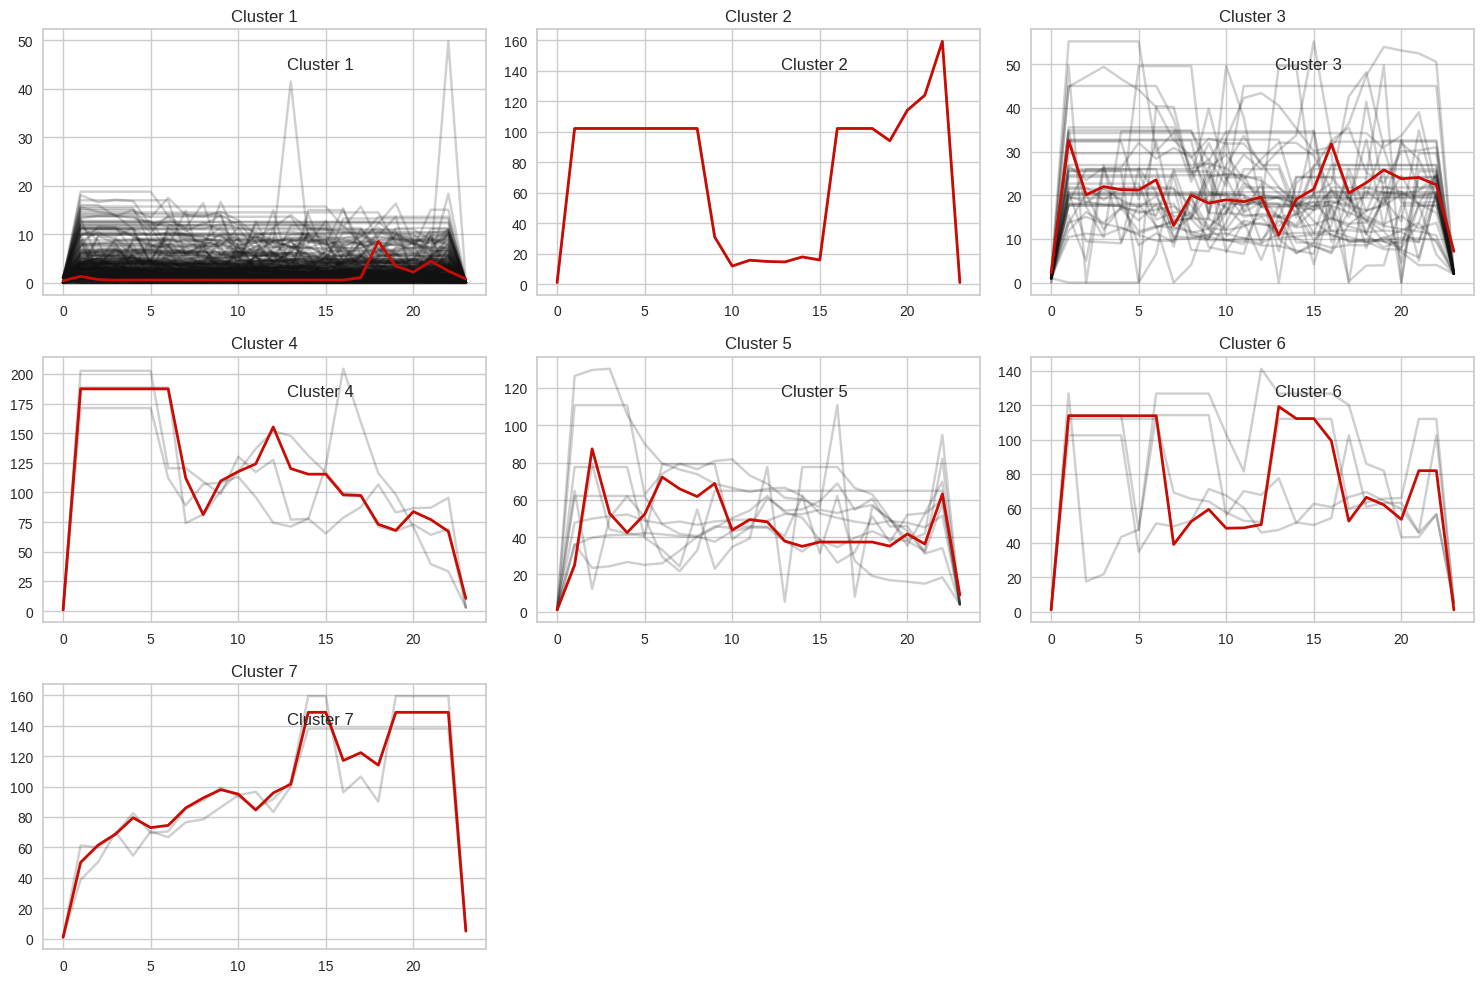

,Country,Cluster
0,Algeria,0
1,Algeria,0
2,Egypt,0
3,Egypt,0
4,Morocco,0
...,...,...
322,American Samoa,2
323,Samoa,0
324,Samoa,0
325,Tonga,0


In [94]:
le = LabelEncoder()
le.fit(df_rate["Sex"])
df_rate["Sex"] = le.transform(df_rate["Sex"])
df_rate = df_rate.apply(lambda row: row.fillna(row['Mean']), axis=1)

to_drop = ["Region", "Subregion", "Country", "Total", "Mean"]
model = TimeSeriesKMeans(n_clusters=7, metric="dtw",max_iter=10)
pred = model.fit_predict(df_rate.drop(to_drop, axis=1))


df_rate["Cluster"] = pred

sz = df_rate.drop(to_drop, axis=1).shape[1]
plt.figure(figsize=(15, 10))


for yi in range(7):
    plt.subplot(3, 3, 1 + yi)
    
    for xx in df_rate.drop(to_drop, axis=1).values[pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=0.2)  
    
    plt.plot(model.cluster_centers_[yi].ravel(), "r-", linewidth=2)  
    plt.text(0.55, 0.85, f'Cluster {yi + 1}', transform=plt.gca().transAxes)
    plt.title(f"Cluster {yi + 1}")

plt.tight_layout()
plt.show()

df_rate[["Country", "Cluster"]]

In [ ]:
region_counts = df_rate.groupby(["Cluster", "Region"]).size().reset_index(name="Count")

most_common_regions = region_counts.loc[region_counts.groupby("Cluster")["Count"].idxmax()]

print("Region la plus représenté par cluster:")
print(most_common_regions)


Most common region in each cluster:
    Cluster    Region  Count
3         0    Europe     94
5         1      Asia      1
7         2  Americas     24
11        3  Americas      3
12        4  Americas      9
14        5  Americas      3
15        6  Americas      2
